In [ ]:
# Import libraries
import pandas as pd
import csv, html, re, requests, pprint, nltk, warnings
import matplotlib.pyplot as plt
import numpy as np
from bs4 import BeautifulSoup
from IPython.display import clear_output
from nltk.tokenize import word_tokenize
nltk.download('punkt')
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
# Mount Drive
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
# Load data
data = pd.read_csv("drive/MyDrive/drugsComTrain_raw.tsv", sep='\t', skiprows=[8072]).drop('Unnamed: 0', axis = 1)
data['review'] = data['review'].apply(html.unescape)

In [ ]:
# View data head
data.head()

,drugName,condition,review,rating,date,usefulCount
0,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9.0,"May 20, 2012",27
1,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8.0,"April 27, 2010",192
2,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5.0,"December 14, 2009",17
3,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8.0,"November 3, 2015",10
4,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9.0,"November 27, 2016",37


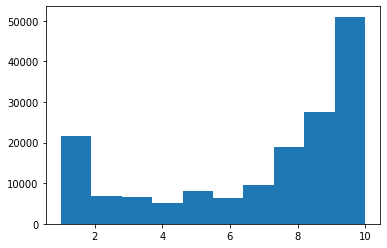

In [ ]:
# See overall rating distribution
plt.hist(data['rating']);

In [ ]:
# Drop NA. Create 'data_clean' dataset
data_clean = data.dropna(subset = ['condition'], axis = 0)

# Drop meaningless conditions
data_clean = data_clean[data_clean['condition'].apply(lambda x: not bool(re.search('</span>', x)))]

In [ ]:
# Define negative/positive ratings thresholds
positive = 9
negative = 4

In [ ]:
# Binarization of ratings
data_clean = data_clean[(data_clean['rating'] >= positive) | (data_clean['rating'] <= negative)]
data_clean['positiveness'] = data_clean['rating'].apply(lambda x: 1 if (x >= positive) else -1)
np.sort(data_clean['rating'].unique())

array([ 1.,  2.,  3.,  4.,  9., 10.])

In [ ]:
def clean_drug_names(drug):
  drug = drug.lower()
  # Run these lines only in fine grained analysis of names (see end of notebook)
  # if drug in changes:
  #   return changes[drug]
  if re.search(r'[\/\\]', drug):
    return drug.split()[0]
  else:
    drug = re.sub("['#]", '', drug)
    return '-'.join(drug.split())


address = ['mtm','','cdi','pro','cons'] # Alternative: add also['ingredient','monograph'] to address
drugs = dict()
def drug_classification(drug):
  if drug in drugs:
    return drugs[drug]
  else:
    for add in address:
      base_url = f"https://www.drugs.com/{add}/{drug.lower()}.html"
      tree = BeautifulSoup(requests.get(base_url).text).find('p',class_='drug-subtitle')
      drug_class = re.findall(r'-class\/(.+).html', str(tree))
      if drug_class: 
        drug_class = drug_class[0]
        drugs[drug] = drug_class
        return drug_class
      return 'NA'

In [ ]:
# Clean drug names
data_clean['drugName'] = data_clean['drugName'].apply(clean_drug_names)

# Create 'drugClass' column
data_clean['drugClass'] = data_clean['drugName'].apply(drug_classification)

In [ ]:
# Separate datasets
na_count = data_clean[data_clean['drugClass'] == 'NA']
data_clean = data_clean[data_clean['drugClass'] != 'NA']

In [ ]:
# Drug names with highest number of NA in drugClass
na_count.groupby('drugName', as_index = False)['drugName', 'drugClass'].count().sort_values('drugClass', ascending = False)

,drugName,drugClass
180,5451,5451
302,1512,1512
271,818,818
437,558,558
119,464,464
...,...,...
356,1,1
357,1,1
358,1,1
175,1,1


In [ ]:
# Drug classes with highest number of reviews
data_clean.groupby('drugClass', as_index = False).count()[['drugName', 'drugClass']].sort_values('drugName', ascending = False)

,drugName,drugClass
142,8898,"contraceptives.html"">Contraceptives</a>, <a hr..."
342,5931,ssri-antidepressants
269,3616,narcotic-analgesics
341,3559,ssnri-antidepressants
96,3402,atypical-antipsychotics
...,...,...
315,1,probiotics
39,1,"antacids.html"">Antacids</a>, <a href=""/drug-cl..."
123,1,carbonic-anhydrase-inhibitors
369,1,"topical-antifungals.html"">Topical antifungals<..."


In [ ]:
len(np.unique(data_clean['drugName']))

2490

In [ ]:
len(np.unique(data_clean['drugClass']))

394

In [ ]:
len(np.unique(data_clean['condition']))

747

In [ ]:
# Save checkpoint data
# data_clean.to_csv(f'data_train_class_{positive}-{negative}.csv')
# !cp data_train_class_9-4.csv "drive/My Drive/"

In [ ]:
def clean_class(drug_class):
  if re.match(r'.*(ceptive).*', drug_class):
    return 'contraceptives'
  elif re.match(r'.*(antidepres).*', drug_class):
    return 'antidepressants'
  elif re.match(r'.*(anorex).*', drug_class):
    return 'anorexiants'
  elif re.match(r'.*(benzodiaz).*', drug_class):
      return 'miscellaneous-anxiolytics-sedatives-and-hypnotics'
  elif re.match(r'.*(analges).*', drug_class):
      return 'miscellaneous-analgesics'
  else:
    return drug_class

In [ ]:
# Clean some classes
data_clean['drugClass'] = data_clean['drugClass'].apply(clean_class)

In [ ]:
# Keep only classes with > 1000 reviews
drug_list = list(data_clean.groupby('drugClass', as_index = False).count()[['drugName', 'drugClass']].sort_values('drugName', ascending = False).iloc[0:14]['drugClass'])
data_clean = data_clean[data_clean['drugClass'].isin(drug_list)]

In [ ]:
# Assert dimension
assert(len(np.unique(data_clean['drugClass'])) == 14)

In [ ]:
# Count positive and negative ratings. Save it in 'group' dataset
group = data_clean.groupby(['drugClass', 'positiveness'], as_index= False).count().sort_values(['drugClass', 'positiveness']).drop('Unnamed: 0', axis = 1)
group['drugName'] = group['drugName'] * group['positiveness']
group

,drugClass,positiveness,drugName,condition,review,rating,date,usefulCount
0,anorexiants,-1,-628,628,628,628,628,628
1,anorexiants,1,3219,3219,3219,3219,3219,3219
2,antidepressants,-1,-4272,4272,4272,4272,4272,4272
3,antidepressants,1,10185,10185,10185,10185,10185,10185
4,antimigraine-agents,-1,-125,125,125,125,125,125
5,antimigraine-agents,1,893,893,893,893,893,893
6,atypical-antipsychotics,-1,-1249,1249,1249,1249,1249,1249
7,atypical-antipsychotics,1,2153,2153,2153,2153,2153,2153
8,cns-stimulants,-1,-535,535,535,535,535,535
9,cns-stimulants,1,1952,1952,1952,1952,1952,1952


In [ ]:
# Count: positive ratings - negative ratings
group = group.groupby('drugClass').sum()[['drugName']]

In [ ]:
# Create balanced dataset named 'drug'
dataset = data_clean
drug = pd.DataFrame(columns = [*dataset.columns])
for name in drug_list:
  nrew = group.loc[name]['drugName']
  if nrew < 0:
    more, less = -1, 1
  else:
    more, less = 1, -1
  df = dataset[(dataset['positiveness'] == more) & (dataset['drugClass'] == name)]
  df = df.drop(df.sample(n = abs(nrew), random_state = 123).index)
  drug = pd.concat([drug, df])
  drug = pd.concat([drug, dataset[(dataset['positiveness'] == less) & (dataset['drugClass'] == name)]])

In [ ]:
drug.shape

(36094, 9)

In [ ]:
print(drug['date'].min(), drug['date'].max())

April 1, 2008 September 9, 2017


In [ ]:
# Save final data
# drug = drug.drop(['usefulCount', 'Unnamed: 0', 'Unnamed: 0.1'], axis = 1)
# drug.to_csv(f'data_train_class_balanced_{positive}-{negative}.csv')
# !cp data_train_class_balanced_9-4.csv "drive/My Drive/"

###  --------------------------------------------------------------------------------------

In [ ]:
## Add this to 'clean_drug_names' function if you want to do a fine-grained analysis

# changes = {
#     'eflornithine': 'eflornithine-topical',
#     'tioconazole': 'tioconazole-vaginal',
#     'ledipasvir' : 'ledipasvir-and-sofosbuvir',
#     'gildess' : 'gildess-24-fe',
#     'ethinyl' : 'ethinyl-estradiol',
#     'elbasvir' : 'elbasvir-and-grazoprevir',
#     'camphor' : 'camphor-gel',
#     'terconazole' : 'terconazole-vaginal',
#     'immune-globulin-oral' : 'immune-globulin',
#     'vicks-sinex-nasal-spray-(old-formulation)' : 'vicks-sinex',
#     'formoterol' : 'formoterol-inhalation',
#     'benzoyl' : 'adapalene-and-benzoyl-peroxide',
#     'a-+-d-cracked-skin-relief' : 'a-d-cracked-skin-relief',
#     'absorbine-jr.' : 'absorbine-jr-antifungal',
#     'acetic' : 'acetic-acid-irrigation-solution',
#     'acrivastine' : 'acrivastine-and-pseudoephedrine',
#     'aflibercept' : 'aflibercept-ophthalmic',
#     'alefacept' : 'amevive',
#     'aleve-d-sinus-&-cold': 'aleve-cold-and-sinus',
#     'allantoin' : 'allantoin-camphor-and-phenol-topical',
#     'allerx-dose-pack-df' : 'methscopolamine',
#     'aloe' : 'aloe-vera-topical',
#     'aloe-vera' : 'aloe-vera-topical',
#     'aluminum' : 'aluminum-acetate',
#     'alyacen' : 'alyacen-7-7-7',
#     'amino-acids' : 'clinimix-n9g20e',
#     'antihemophilic' : 'antihemophilic-factor-recombinant-porcine-sequence',
#     'antipyrine' : 'antipyrine-benzocaine-glycerin-zinc-ear-drops',
#     'artemether' : 'artemether-and-lumefantrine',
#     'azelaic-acid' : 'azelaic-acid-topical',
#     'azithromycin-dose-pack' : 'azithromycin',
#     'balsam' : 'balsam-peru-and-castor-oil-topical',
#     'bazedoxifene' : 'bazedoxifene-and-conjugated-estrogens',
#     'beclomethasone' : 'beclomethasone-inhalation',
#     'benadryl-allergy-sinus' : 'benadryl-allergy',
#     'benzalkonium' : 'benzalkonium-chloride',
#     'benzefoam' : 'benzefoam-ultra-topical',
#     'benzoic' : 'urised',
#     'betadine-aerosol-spray' : 'betadine',
#     'bimatoprost' : 'bimatoprost-ophthalmic',
#     'bismuth' : 'bismuth-subsalicylate-suspension',
#     'blisovi' : 'blisovi-24-fe',
#     'brovex-peb-dm' : 'brovex-pse-dm',
#     'c1-esterase-inhibitor-(human)': 'c1-esterase-inhibitor-human',
#     'capsaicin' : 'capsaicin-topical',
#     'citric' : 'sodium-citrate-and-citric-acid',
#     'dasabuvir' : 'dasabuvir-ombitasvir-paritaprevir-and-ritonavir',
#     'depo-provera':'provera',
#     'emollients' : 'topical-emollients',
#     'epiceram' : 'epiceram-skin-barrier',
#     'esterified' : 'estrogens-esterified-and-methyltestosterone',
#     'imiquimod' : 'imiquimod-topical',
#     'insuline' : 'insulin-parenteral',
#     'insuline-glargine' : 'insulin-parenteral',
#     'lo' : 'lo_ovral',
#     'loteprednol' : 'loteprednol-ophthalmic',
#     'mometasone' : 'mometasone-topical',
#     'mucinex-d' : 'mucinex-dm',
#     'mucinex-d-maximum-strength' : 'mucinex-dm',
#     'mupirocin' : 'mupirocin-topical'
# }